# Linear Regression - By Foivos Gaitantzis

#### This section of the program is dedicated to fitting all the features post processing to a Linear Regression Algorithm. An initial model is built using random hyperparametes. The hyperparameter values are then tweaked and a final model is built and evaluated. 

### Load the Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

### Define the Feature Engineering/Machine Learning Parameters & Utility Functions

In [2]:
#Set the filename
filename = 'aapl'

#Set the Default Columns, Timestep (Previous Historical Data to Use for Predictions) & Polynomial Degree
Columns = ['Adj Close', 'compoundFT', 'compoundNYTimes', 'compoundBS', 'Volume', 'RSI', 'MACD']
timestep = 3
polynomial_degree = 1

In [3]:
#Utility function to compute the mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

### Load the Data File & Perform Model Feature Engineering

In [4]:
#Load the Daily Stock Data
Data = pd.read_csv('files/'+filename+'_Stock_Data_Full.csv')

#Set the Date Column Type to Datetime
Data['Date'] = pd.to_datetime(Data['Date'], format='%Y-%m-%d')

#Create copies of the Data for Modification
Data_Edit = Data.copy()
Columns_Edit = Columns.copy()

#Create new to columns of Historical Data according to the timestep
for step in range(timestep):
    Columns_Edit.append('Adj Close'+str(step))
    Data_Edit['Adj Close'+str(step)] = Data_Edit['Adj Close']
    Data_Edit['Adj Close'+str(step)] = Data_Edit['Adj Close'+str(step)].shift(step)

#Remove all NaN values in Adj Close, Adj Close(0 - timestep), Predicted Adj Close, RSI and MACD
Data_Edit.dropna(inplace = True)

#Display the first 5 rows of the Modified Data Set
Data_Edit.head()

,Date,compoundFT,compoundNYTimes,compoundBS,Close,Volume,Adj Close,RSI,MACD,Predicted Adj Close,Adj Close0,Adj Close1,Adj Close2
7,2016-01-08,0.203480,0.043943,0.137486,96.959999,7.079800e+07,90.391907,14.668720,-0.370537,90.879794,90.391907,89.916473,93.878586
8,2016-01-09,0.377325,-0.008900,0.104625,97.483332,6.377847e+07,90.879794,14.832344,-0.384101,91.367681,90.879794,90.391907,89.916473
9,2016-01-10,0.515333,0.271481,0.135400,98.006666,5.675893e+07,91.367681,14.886746,-0.364081,91.855568,91.367681,90.879794,90.391907
10,2016-01-11,0.233810,0.375018,0.179233,98.529999,4.973940e+07,91.855568,14.913921,-0.321599,93.188705,91.855568,91.367681,90.879794
11,2016-01-12,0.155050,0.201992,0.397150,99.959999,4.915420e+07,93.188705,19.135019,-0.221146,90.792793,93.188705,91.855568,91.367681


In [5]:
#Split the Data into Training and Testing (Train: 80% & Testing: 20%)
train, test = train_test_split(Data_Edit, train_size = 0.8, test_size = 0.2, shuffle = False)

#Initiate two Scalers: one for the inputs & one for the output
ScalerX = StandardScaler()

#Seperate the train & test dataset into their inputs and output & perform scaling
x_train = ScalerX.fit_transform(train[Columns_Edit])
y_train = train[['Predicted Adj Close']]
x_test = ScalerX.transform(test[Columns_Edit])
y_test = test[['Predicted Adj Close']]

#Intiatize the Polynomial Features & apply it on the Model inputs
Polynomial = PolynomialFeatures(degree=polynomial_degree)
x_train = Polynomial.fit_transform(x_train)
x_test = Polynomial.fit_transform(x_test)

### Run the Primary Linear Regression Model using Default Parameters

In [6]:
#Initialize the Model
Model = LinearRegression(n_jobs=-1)

#Fit the Training Inputs and Output into the Model
Model.fit(x_train, np.array(y_train).ravel())

#Using the Test Inputs, Predict Values for Output
Prediction = Model.predict(x_test)

#Calculate the Root Mean Squared Error & the Mean Absolute Percentage Error
RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'], Prediction))
MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'], Prediction)

#Print the values of Accuracy, RMSE & MAPE
print("Accuracy: "+str(Model.score(x_test, np.array(y_test).ravel())))
print("RMSE: "+str(RMSE))
print("MAPE: "+str(MAPE))

#Create a Dataframe that stores the Date, the Actual Stock Value and the Predicted Stock Value
Prediction = pd.DataFrame({'Date': test['Date'], 'Actual Value': test['Predicted Adj Close'], 'Prediction': Prediction})

#Display the first 5 rows of this Dataframe
Prediction.head()

Accuracy: 0.9807114869939384
RMSE: 2.818653419593127
MAPE: 0.9381475643826316


,Date,Actual Value,Prediction
877,2018-05-27,183.560894,183.623894
878,2018-05-28,183.394974,183.557902
879,2018-05-29,183.004562,183.346332
880,2018-05-30,182.389633,182.961889
881,2018-05-31,185.678833,182.310056


### Display Primary Model Predictions vs Actual Values

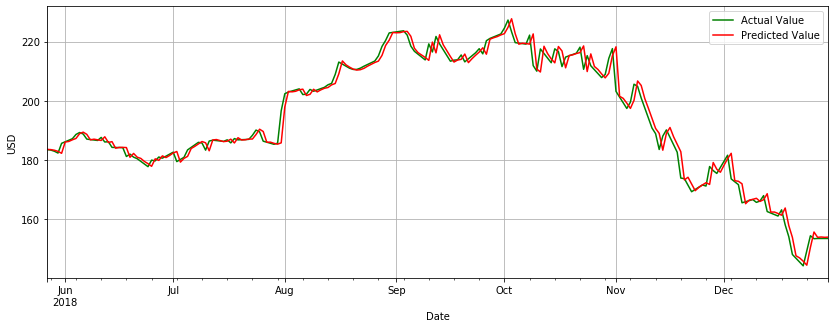

In [7]:
#Display a line graph of the Actual vs Predicted Values
plt.rcParams['figure.figsize'] = 14, 5 
AX = Prediction.plot(x='Date', y='Actual Value', style='g-', grid=True)
AX = Prediction.plot(x='Date', y='Prediction', style='r-', grid=True, ax=AX)
AX.legend(['Actual Value', 'Predicted Value'])
AX.set_xlabel("Date")
AX.set_ylabel("USD")
plt.show()

### Calculate the Optimal Columns Type

In [8]:
columns_list = [['Adj Close', 'Volume'], ['Adj Close', 'Volume', 'RSI', 'MACD'], ['Adj Close', 'Volume', 'compoundFT', 'compoundNYTimes'], Columns]
columns_headers = ['Just Historical Stock Data', 'Technical Analysis', 'Sentiment Analysis', 'Technical & Sentiment Analysis']

columns_errors = {'Columns' : [], 'Columns Type' : [], 'RMSE' : [], 'MAPE' : []}
i = 0

for column in columns_list:   
    
    Data_Edit = Data.copy()
    for step in range(timestep):
        Columns_Edit.append('Adj Close'+str(step))
        Data_Edit['Adj Close'+str(step)] = Data_Edit['Adj Close']
        Data_Edit['Adj Close'+str(step)] = Data_Edit['Adj Close'+str(step)].shift(step)
    
    #Remove all NaN values in Adj Close, Adj Close(0 - timestep), Predicted Adj Close, RSI and MACD
    Data_Edit.dropna(inplace = True)
    
    #Split the Data into Training and Testing (Train: 80% & Testing: 20%)
    train, test = train_test_split(Data_Edit, train_size = 0.8, test_size = 0.2, shuffle = False)

    #Initiate two Scalers: one for the inputs & one for the output
    ScalerX = StandardScaler()

    #Seperate the train & test dataset into their inputs and output & perform scaling
    x_train = ScalerX.fit_transform(train[column])
    y_train = train[['Predicted Adj Close']]
    x_test = ScalerX.transform(test[column])
    y_test = test[['Predicted Adj Close']]
    
    #Intiatize the Polynomial Features & apply it on the Model inputs
    Polynomial = PolynomialFeatures(degree=polynomial_degree)
    x_train = Polynomial.fit_transform(x_train)
    x_test = Polynomial.fit_transform(x_test)
    
    #Initialize the Model
    Model = LinearRegression()

    #Fit the Training Inputs and Output into the Model
    Model.fit(x_train, np.array(y_train).ravel())
    
    #Using the Test Inputs, Predict Values for Output
    Prediction = Model.predict(x_test)

    #Print the values of Accuracy, RMSE & MAPE
    RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'], Prediction))
    MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'], Prediction)
    
    #Input the Columns, Columns Type & Errors to the Dataframe
    columns_errors['Columns'].append(column)
    columns_errors['Columns Type'].append(columns_headers[i])
    columns_errors['RMSE'].append(RMSE)
    columns_errors['MAPE'].append(MAPE)
    
    i+=1
    
columns_errors = pd.DataFrame(columns_errors)
                              
#Set the Data Column as Index Column
columns_errors = columns_errors.set_index('Columns Type')

#Print the Optimal Columns Type
OptimalParameter = columns_errors[columns_errors['RMSE'] == columns_errors['RMSE'].min()]
Columns = OptimalParameter['Columns'].values[0]
print("Optimal Parameter (Based on RMSE): "+str(OptimalParameter.index.values[0])+", RMSE: "+str(OptimalParameter['RMSE'].values[0]))

#Show each Columns Type and Error Associated
columns_errors[['RMSE', 'MAPE']].head()

Optimal Parameter (Based on RMSE): Sentiment Analysis, RMSE: 2.7855719381812527


,RMSE,MAPE
Columns Type,,
Just Historical Stock Data,2.789762,0.944860
Technical Analysis,2.826943,0.963696
Sentiment Analysis,2.785572,0.941622
Technical & Sentiment Analysis,2.824755,0.962512


### Calculate the Optimal Timestep

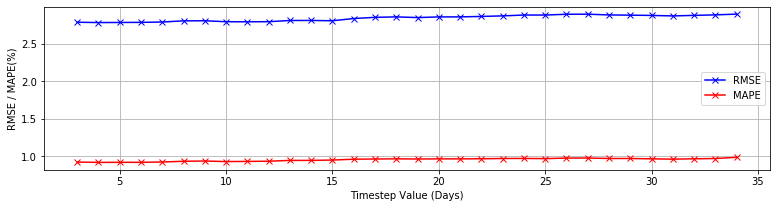

Optimal Parameter (Based on RMSE): 4, RMSE: 2.7829077212014925


In [9]:
timestep_list = range(3, 35)

timestep_errors = {'Timestep' : [], 'RMSE' : [], 'MAPE' : []}

for step in timestep_list:   
    
    Columns_Edit = Columns.copy()
    Data_Edit = Data.copy()
    for step_update in range(step):
        Columns_Edit.append('Adj Close'+str(step_update))
        Data_Edit['Adj Close'+str(step_update)] = Data_Edit['Adj Close']
        Data_Edit['Adj Close'+str(step_update)] = Data_Edit['Adj Close'+str(step_update)].shift(step_update)

    #Remove all NaN values in Adj Close, Adj Close(0 - timestep), Predicted Adj Close, RSI and MACD
    Data_Edit.dropna(inplace = True)
    
    #Split the Data into Training and Testing (Train: 80% & Testing: 20%)
    train, test = train_test_split(Data_Edit, train_size = 0.8, test_size = 0.2, shuffle = False)

    #Initiate two Scalers: one for the inputs & one for the output
    ScalerX = StandardScaler()

    #Seperate the train & test dataset into their inputs and output & perform scaling
    x_train = ScalerX.fit_transform(train[Columns_Edit])
    y_train = train[['Predicted Adj Close']]
    x_test = ScalerX.transform(test[Columns_Edit])
    y_test = test[['Predicted Adj Close']]
    
    #Intiatize the Polynomial Features & apply it on the Model inputs
    Polynomial = PolynomialFeatures(degree=polynomial_degree)
    x_train = Polynomial.fit_transform(x_train)
    x_test = Polynomial.fit_transform(x_test)
    
    #Initialize the Model
    Model = LinearRegression()

    #Fit the Training Inputs and Output into the Model
    Model.fit(x_train, np.array(y_train).ravel())
    
    #Using the Test Inputs, Predict Values for Output
    Prediction = Model.predict(x_test)

    #Print the values of Accuracy, RMSE & MAPE
    RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'], Prediction))
    MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'], Prediction)
    
    #Input the Timestep & Errors to the Dataframe
    timestep_errors['Timestep'].append(step)
    timestep_errors['RMSE'].append(RMSE)
    timestep_errors['MAPE'].append(MAPE)
    
timestep_errors = pd.DataFrame(timestep_errors)

#Plot the Errors against the Timestep
plt.rcParams['figure.figsize'] = 13, 3 
AX = timestep_errors.plot(x='Timestep', y='RMSE', style='bx-', grid=True)
AX = timestep_errors.plot(x='Timestep', y='MAPE', style='rx-', grid=True, ax=AX)
AX.set_xlabel("Timestep Value (Days)")
AX.set_ylabel("RMSE / MAPE(%)")
plt.show()

#Print the Optimal Timestep and Set it to the Default
OptimalParameter = timestep_errors[timestep_errors['RMSE'] == timestep_errors['RMSE'].min()]
timestep = OptimalParameter['Timestep'].values[0]
print("Optimal Parameter (Based on RMSE): "+str(OptimalParameter['Timestep'].values[0])+", RMSE: "+str(OptimalParameter['RMSE'].values[0]))

### Calculate the Optimal Polynomial Degree

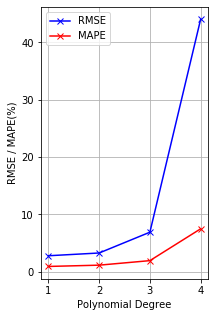

Optimal Parameter (Based on RMSE): 1, RMSE: 2.7829077212014925


In [10]:
polynomial_list = range(1, 5)

polynomial_errors = {'Polynomial Degree' : [], 'RMSE' : [], 'MAPE' : []}

for degree in polynomial_list:   
    
    Columns_Edit = Columns.copy()
    Data_Edit = Data.copy()
    for step in range(timestep):
        Columns_Edit.append('Adj Close'+str(step))
        Data_Edit['Adj Close'+str(step)] = Data_Edit['Adj Close']
        Data_Edit['Adj Close'+str(step)] = Data_Edit['Adj Close'+str(step)].shift(step)

    #Remove all NaN values in Adj Close, Adj Close(0 - timestep), Predicted Adj Close, RSI and MACD
    Data_Edit.dropna(inplace = True)
    
    #Split the Data into Training and Testing (Train: 80% & Testing: 20%)
    train, test = train_test_split(Data_Edit, train_size = 0.8, test_size = 0.2, shuffle = False)

    #Initiate two Scalers: one for the inputs & one for the output
    ScalerX = StandardScaler()
    
    #Seperate the train & test dataset into their inputs and output & perform scaling
    x_train = ScalerX.fit_transform(train[Columns_Edit])
    y_train = train[['Predicted Adj Close']]
    x_test = ScalerX.transform(test[Columns_Edit])
    y_test = test[['Predicted Adj Close']]
    
    #Intiatize the Polynomial Features & apply it on the Model inputs
    Polynomial = PolynomialFeatures(degree=degree)
    x_train = Polynomial.fit_transform(x_train)
    x_test = Polynomial.fit_transform(x_test)
    
    #Initialize the Model
    Model = LinearRegression()

    #Fit the Training Inputs and Output into the Model
    Model.fit(x_train, np.array(y_train).ravel())
    
    #Using the Test Inputs, Predict Values for Output
    Prediction = Model.predict(x_test)

    #Print the values of Accuracy, RMSE & MAPE
    RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'], Prediction))
    MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'], Prediction)
    
    #Input the Degree & Errors to the Dataframe
    polynomial_errors['Polynomial Degree'].append(degree)
    polynomial_errors['RMSE'].append(RMSE)
    polynomial_errors['MAPE'].append(MAPE)
    
polynomial_errors = pd.DataFrame(polynomial_errors)

#Plot the Errors against the Degree
plt.rcParams['figure.figsize'] = 3, 5 
AX = polynomial_errors.plot(x='Polynomial Degree', y='RMSE', style='bx-', grid=True)
AX = polynomial_errors.plot(x='Polynomial Degree', y='MAPE', style='rx-', grid=True, ax=AX)
AX.set_xlabel("Polynomial Degree")
AX.set_ylabel("RMSE / MAPE(%)")
plt.show()

#Print the Optimal Degree and Set it to the Default
OptimalParameter = polynomial_errors[polynomial_errors['RMSE'] == polynomial_errors['RMSE'].min()]
polynomial_degree = OptimalParameter['Polynomial Degree'].values[0]
print("Optimal Parameter (Based on RMSE): "+str(OptimalParameter['Polynomial Degree'].values[0])+", RMSE: "+str(OptimalParameter['RMSE'].values[0]))

### Final Model (including Feature Engineering)

In [11]:
#Create copies of the Data for Modification
Data_Edit = Data.copy()
Columns_Edit = Columns.copy()

#Create new to columns of Historical Data according to the timestep
for step in range(timestep):
    Columns_Edit.append('Adj Close'+str(step))
    Data_Edit['Adj Close'+str(step)] = Data_Edit['Adj Close']
    Data_Edit['Adj Close'+str(step)] = Data_Edit['Adj Close'+str(step)].shift(step)

#Remove all NaN values in Adj Close, Adj Close(0 - timestep), Predicted Adj Close, RSI and MACD
Data_Edit.dropna(inplace = True)

#Split the Data into Training and Testing (Train: 80% & Testing: 20%)
train, test = train_test_split(Data_Edit, train_size = 0.8, test_size = 0.2, shuffle = False)

#Initiate two Scalers: one for the inputs & one for the output
ScalerX = StandardScaler()

#Seperate the train & test dataset into their inputs and output & perform scaling
x_train = ScalerX.fit_transform(train[Columns_Edit])
y_train = train[['Predicted Adj Close']]
x_test = ScalerX.transform(test[Columns_Edit])
y_test = test[['Predicted Adj Close']]

#Intiatize the Polynomial Features & apply it on the Model inputs
Polynomial = PolynomialFeatures(degree=polynomial_degree)
x_train = Polynomial.fit_transform(x_train)
x_test = Polynomial.fit_transform(x_test)

In [12]:
#Initialize the Model
Model = LinearRegression(n_jobs=-1)

#Fit the Training Inputs and Output into the Model
Model.fit(x_train, np.array(y_train).ravel())

#Using the Test Inputs, Predict Values for Output
Prediction = Model.predict(x_test)

#Calculate the Root Mean Squared Error & the Mean Absolute Percentage Error
RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'], Prediction))
MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'], Prediction)

#Print the values of Accuracy, RMSE & MAPE
print("Accuracy: "+str(Model.score(x_test, np.array(y_test).ravel())))
print("RMSE: "+str(RMSE))
print("MAPE: "+str(MAPE))

#Create a Dataframe that stores the Date, the Actual Stock Value and the Predicted Stock Value
Prediction = pd.DataFrame({'Date': test['Date'], 'Actual Value': test['Predicted Adj Close'], 'Prediction': Prediction})

#Display the first 5 rows of this Dataframe
Prediction.head()

Accuracy: 0.9811976123323733
RMSE: 2.7829077212014925
MAPE: 0.9164240474569563


,Date,Actual Value,Prediction
877,2018-05-27,183.560894,183.709449
878,2018-05-28,183.394974,183.606060
879,2018-05-29,183.004562,183.392529
880,2018-05-30,182.389633,182.978926
881,2018-05-31,185.678833,182.343794


### Display Final Model Predictions vs Actual Values

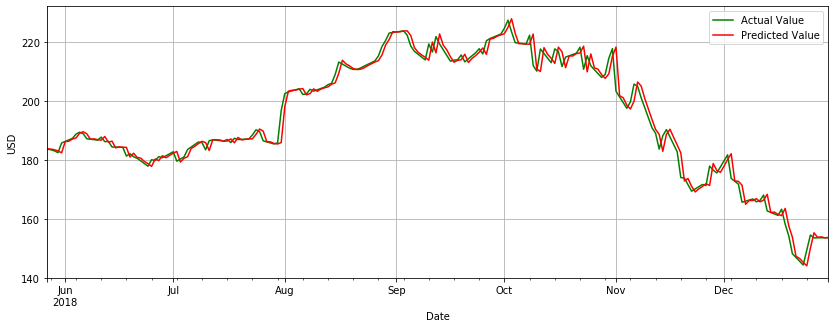

In [75]:
#Display a line graph of the Actual vs Predicted Values
plt.rcParams['figure.figsize'] = 14, 5 
AX = Prediction.plot(x='Date', y='Actual Value', style='g-', grid=True)
AX = Prediction.plot(x='Date', y='Prediction', style='r-', grid=True, ax=AX)
AX.legend(['Actual Value', 'Predicted Value'])
AX.set_xlabel("Date")
AX.set_ylabel("USD")
plt.show()